In [1]:
# This cell imports all the necessary python packages needed for analyzing the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import scatter_matrix
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as smt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the preprocessed data
data = pd.read_csv("data/data_for_analysis.csv")

## Deal with missing data and categories
- when hbcu is missing, fill it with 0, since 0 is mode of hbcu
- when venue_type is N/A, assign it as "others" category
- when venue_type is Slam, assign it as "others" category. The reason is there are very few datapoints with Slam venue_type.

In [3]:
data[["hbcu"]] = data[["hbcu"]].replace({0: False, 1: True})
data[['hbcu']] = data[['hbcu']].fillna(0)
data[['venue_type']] = data[['venue_type']].fillna('Others')
data[["venue_type"]] = data[["venue_type"]].replace({'Slam': 'Others'})

In [4]:
data.shape

(203, 44)

## Take the absolute values of "IntensityMeanAbsVelocity" according to our discussions

In [5]:
data['IntensityMeanAbsVelocity'] = np.abs(data['IntensityMeanAbsVelocity'])

# Box plots

In [6]:
####################
# Boxplot and test #
####################
def boxplot(measure_name_vet, data_frame, figsize):
    for measure_name in measure_name_vet:
        response_column = data_frame[measure_name]
        column_name_vet = ["undergrad_study_indicator", "spoken_word", 'venue_type', 'hbcu', "graduate_study_indicator",
                           "cave_canem_indicator", "public_private_indicator", "region", "Ivy"]
        label_vet=["Undergraduate", 'Spoken Word', 'Venue Type', 'HBCU', "Graduate", "Cave Canem", "Public or Private", "Region", "Ivy"]
        categorical_data_frame = data_frame[column_name_vet]

        fig, ax = plt.subplots(3, 3, figsize=figsize)
        for i, sub_ax in enumerate(ax.reshape(-1)):
            category_vet = np.unique(categorical_data_frame.iloc[:, i])
            response_vet = [response_column[categorical_data_frame.iloc[:, i] == category] for category in
                            category_vet]
            if column_name_vet[i] == "region":
                region_name_vet = ['Caribbean', 'Midwest', 'NYC', 'Northeast', 'South', 'West', 'Various', 'Other']
                region_response_vet = []
                for region in region_name_vet:
                    region_response_vet.append(response_vet[np.where(category_vet == region)[0][0]])

                sub_ax.boxplot(region_response_vet, labels=region_name_vet)
                sub_ax.set_title(label_vet[i])
            elif column_name_vet[i] == 'venue_type':
                region_name_vet = ['Academic', 'Studio', 'participatory setting', 'public reading space', 
                                   'self-recorded', "Unknown", "Inauguration"]
                region_response_vet = []
                for region in region_name_vet:
                    # print(category_vet, region, np.where(category_vet == region))
                    region_response_vet.append(response_vet[np.where(category_vet == region)[0][0]])
                sub_ax.boxplot(region_response_vet, labels=region_name_vet)
                sub_ax.set_title(label_vet[i])
            else:
                sub_ax.boxplot(response_vet, labels=category_vet)
                sub_ax.set_xticklabels(["No", "Yes"])
                sub_ax.set_title(label_vet[i])
        plt.tight_layout()

        fig.suptitle(measure_name, y = 1.02, fontweight ="bold")
        plt.savefig('data/boxplots_' + measure_name + '.pdf')
        plt.show()

## Box plots of "f0Mean"

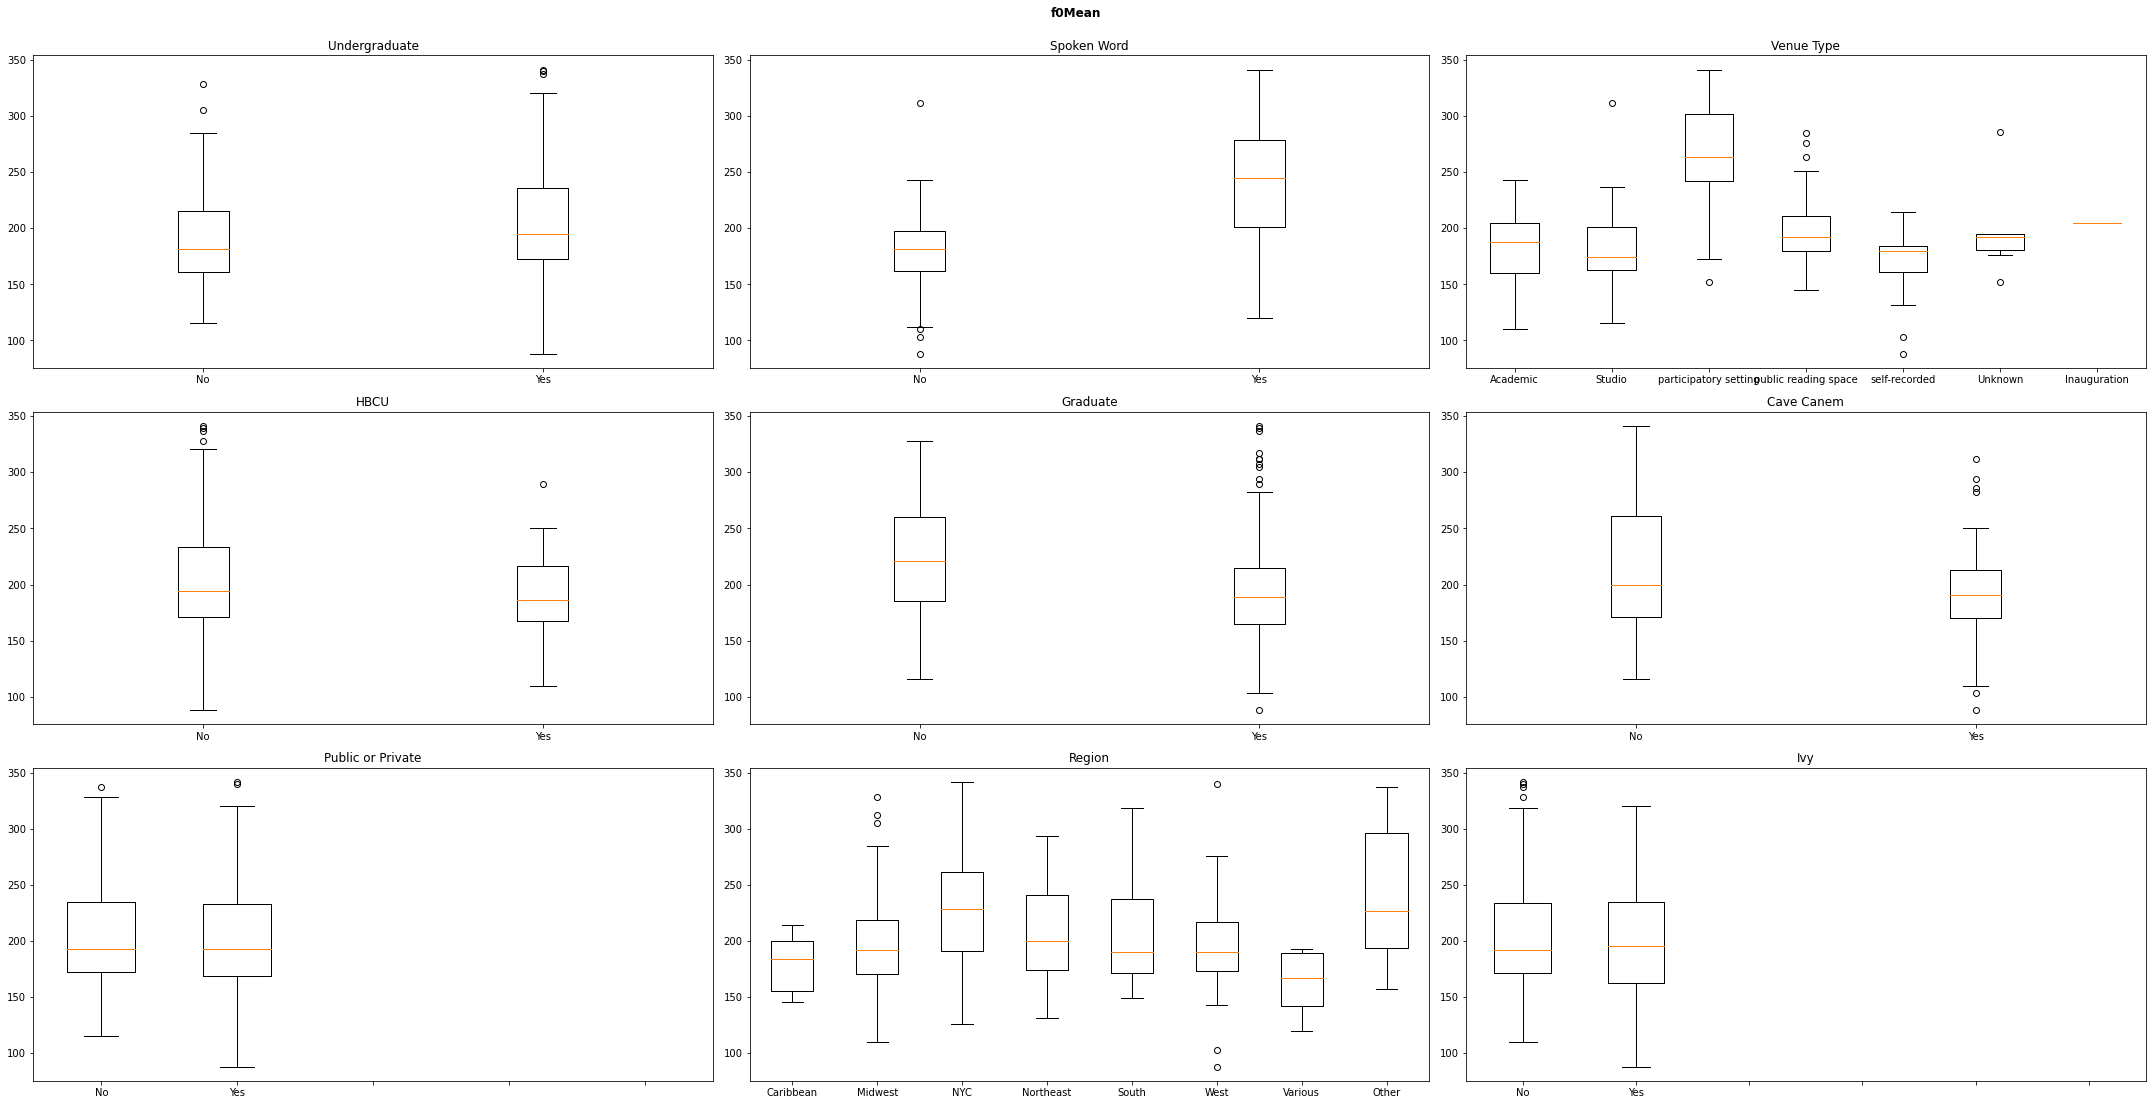

In [7]:
_ = boxplot(measure_name_vet=['f0Mean'], data_frame=data, figsize=(30,15))

## Box plots of "f0MeanAbsVelocity"

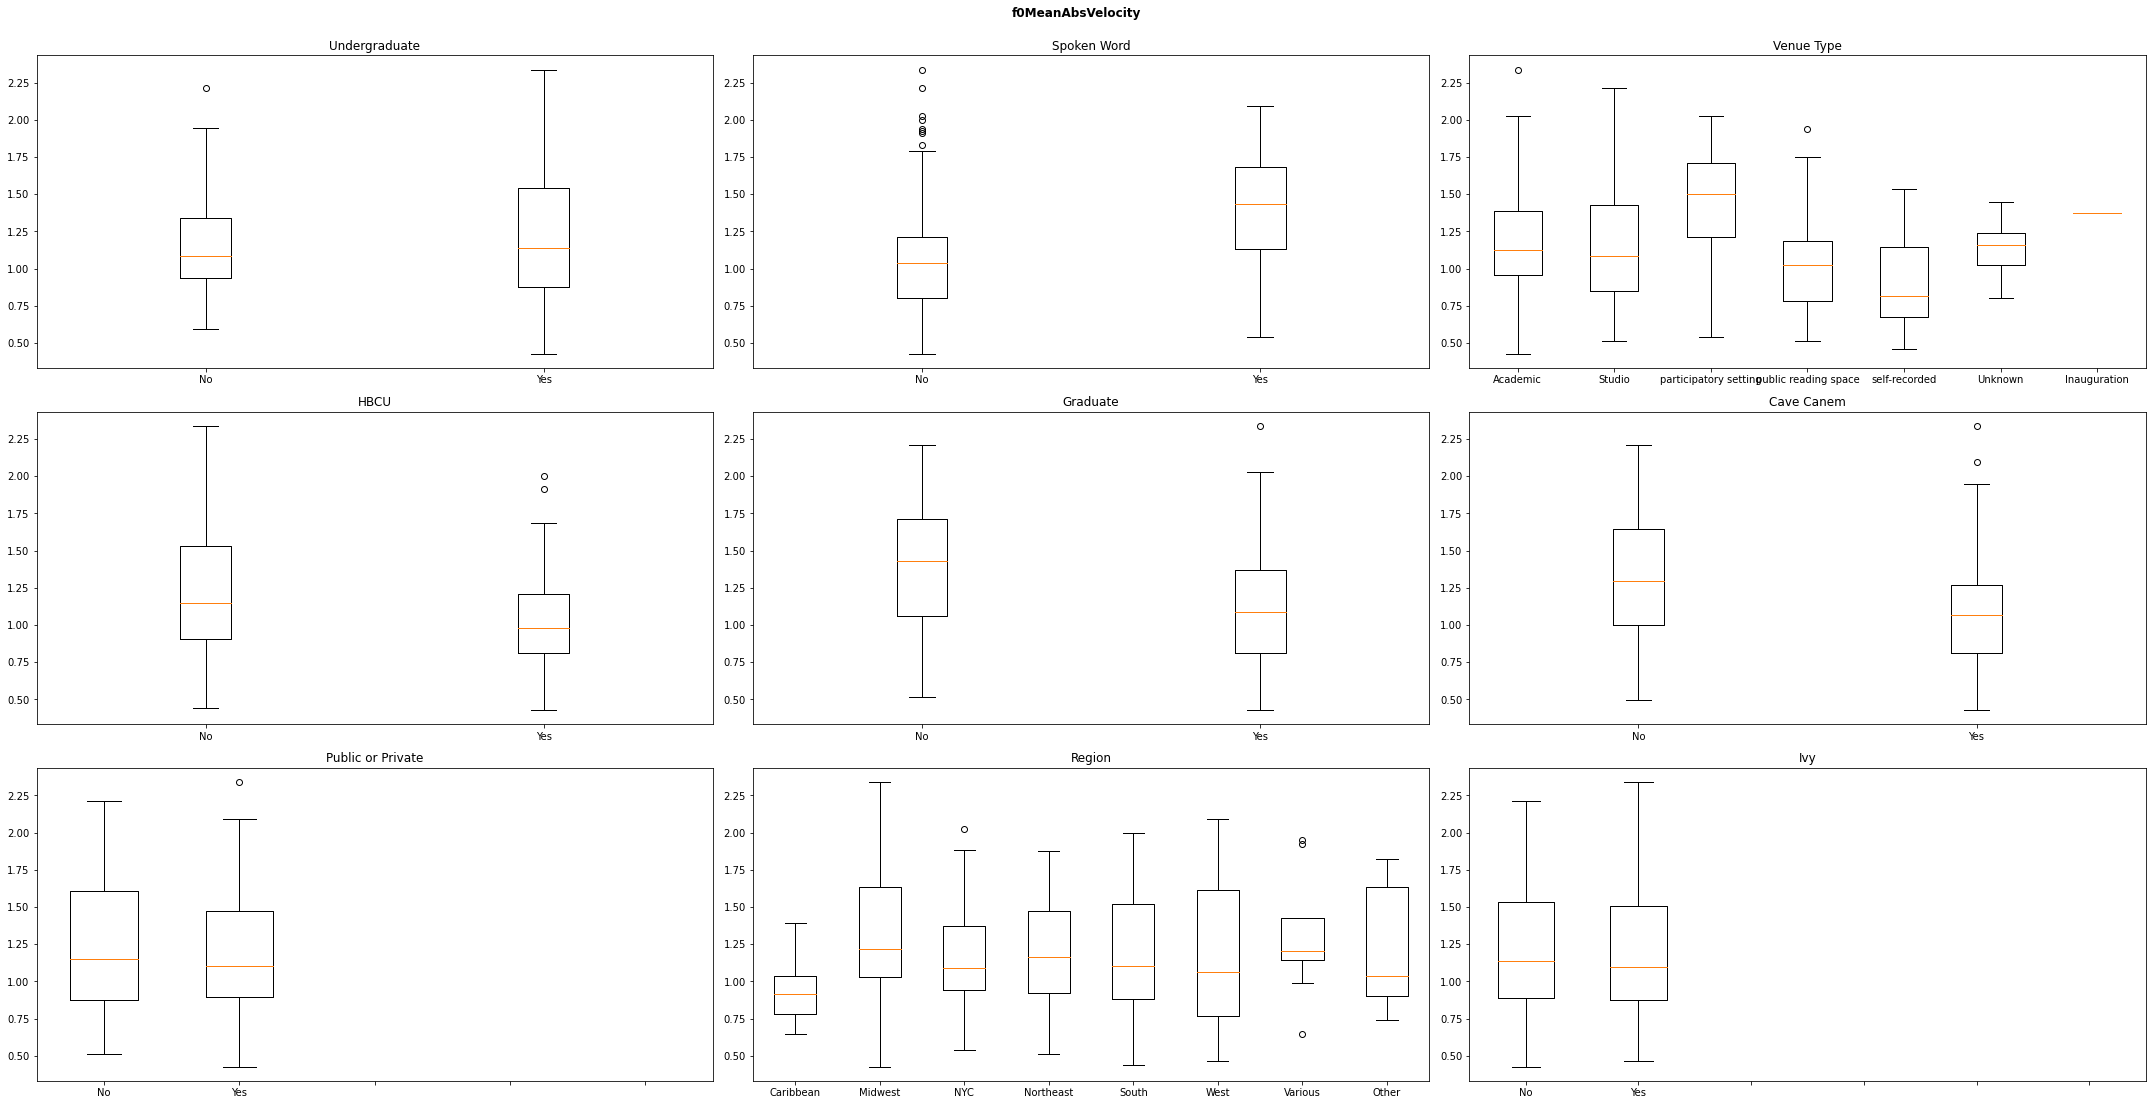

In [8]:
_ = boxplot(measure_name_vet=["f0MeanAbsVelocity"], data_frame=data, figsize=(30,15))

## Box plots of "Dynamism"

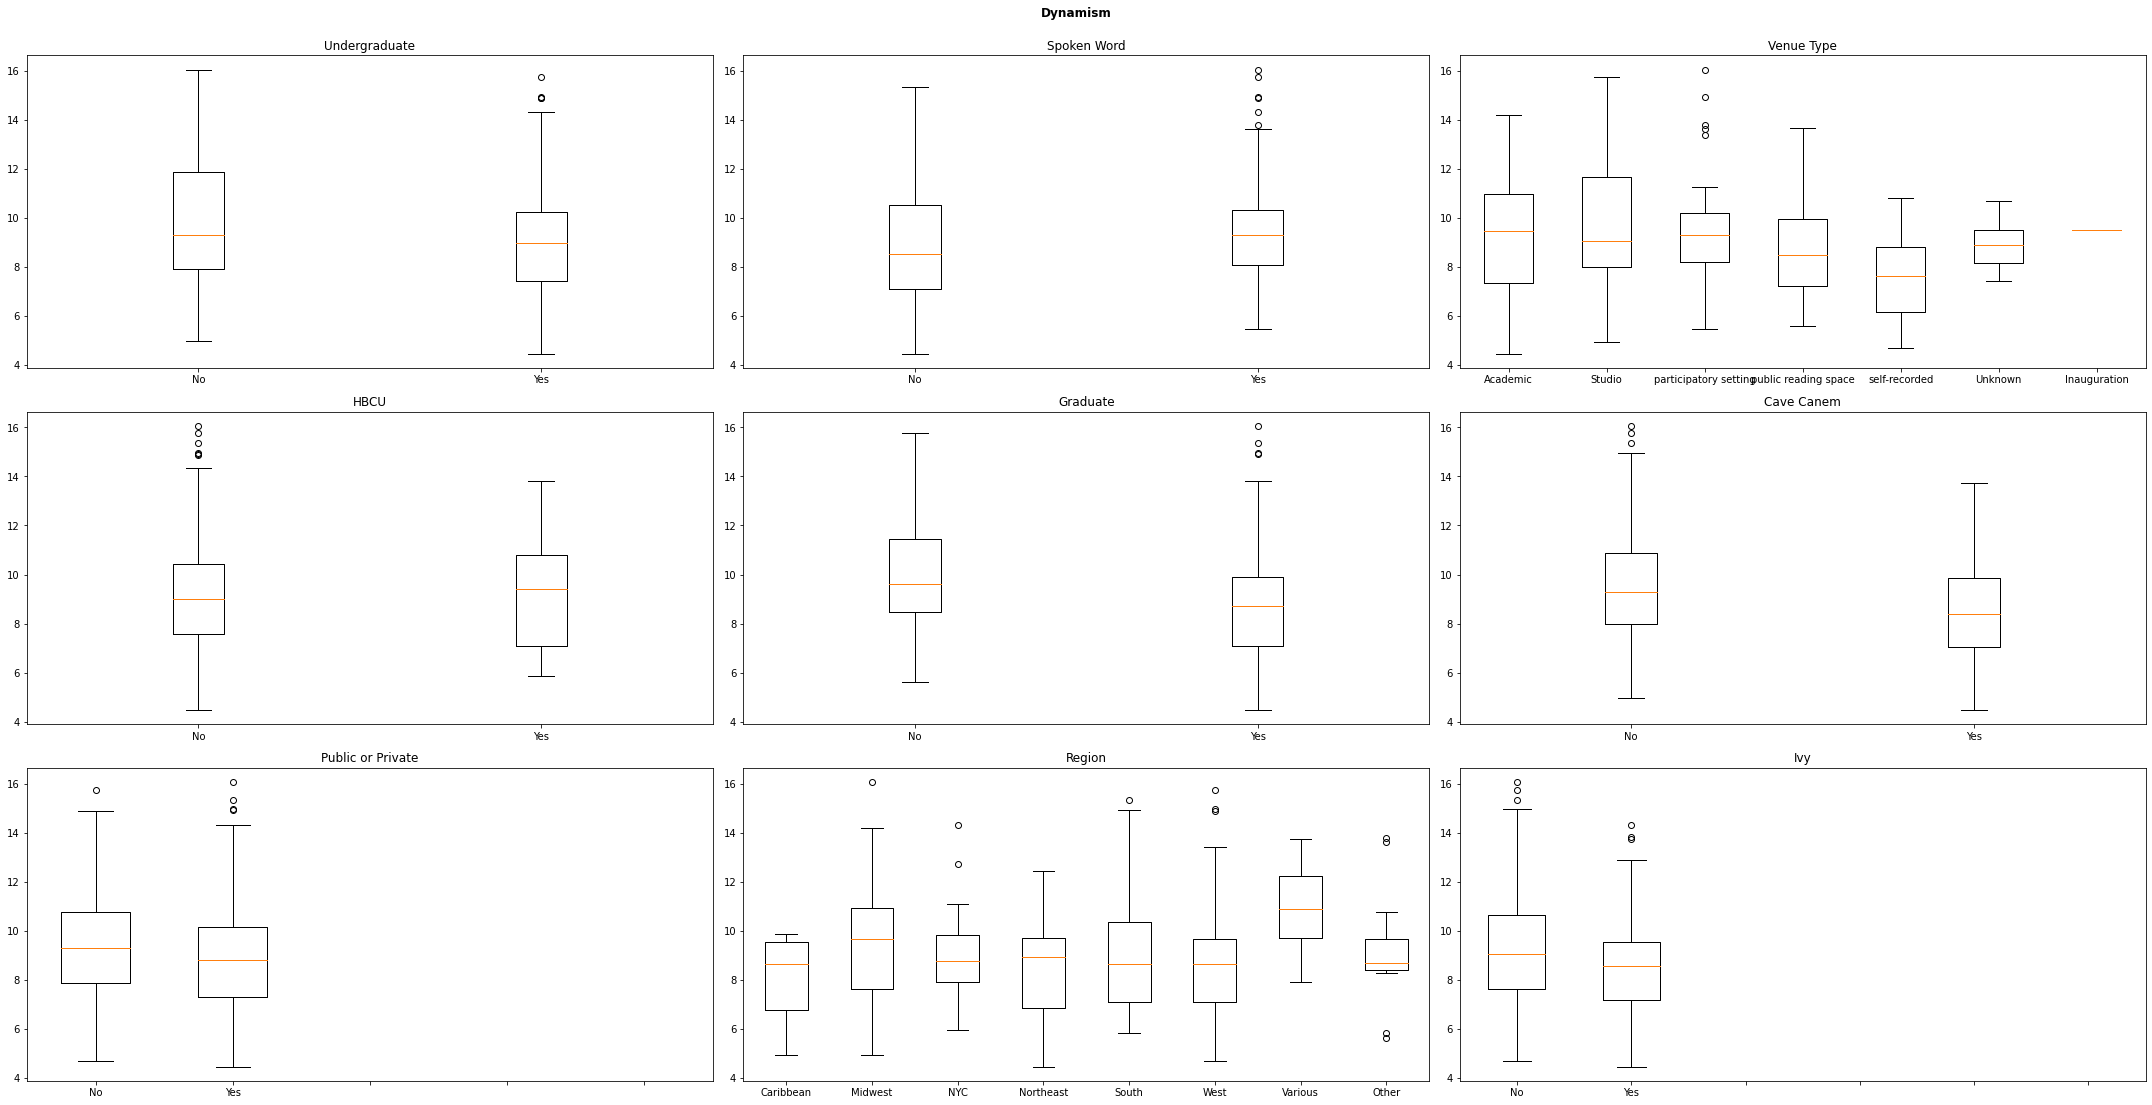

In [9]:
_ = boxplot(measure_name_vet=["Dynamism"], data_frame=data, figsize=(30,15))

## Box plots of "MeanPauseDuration"

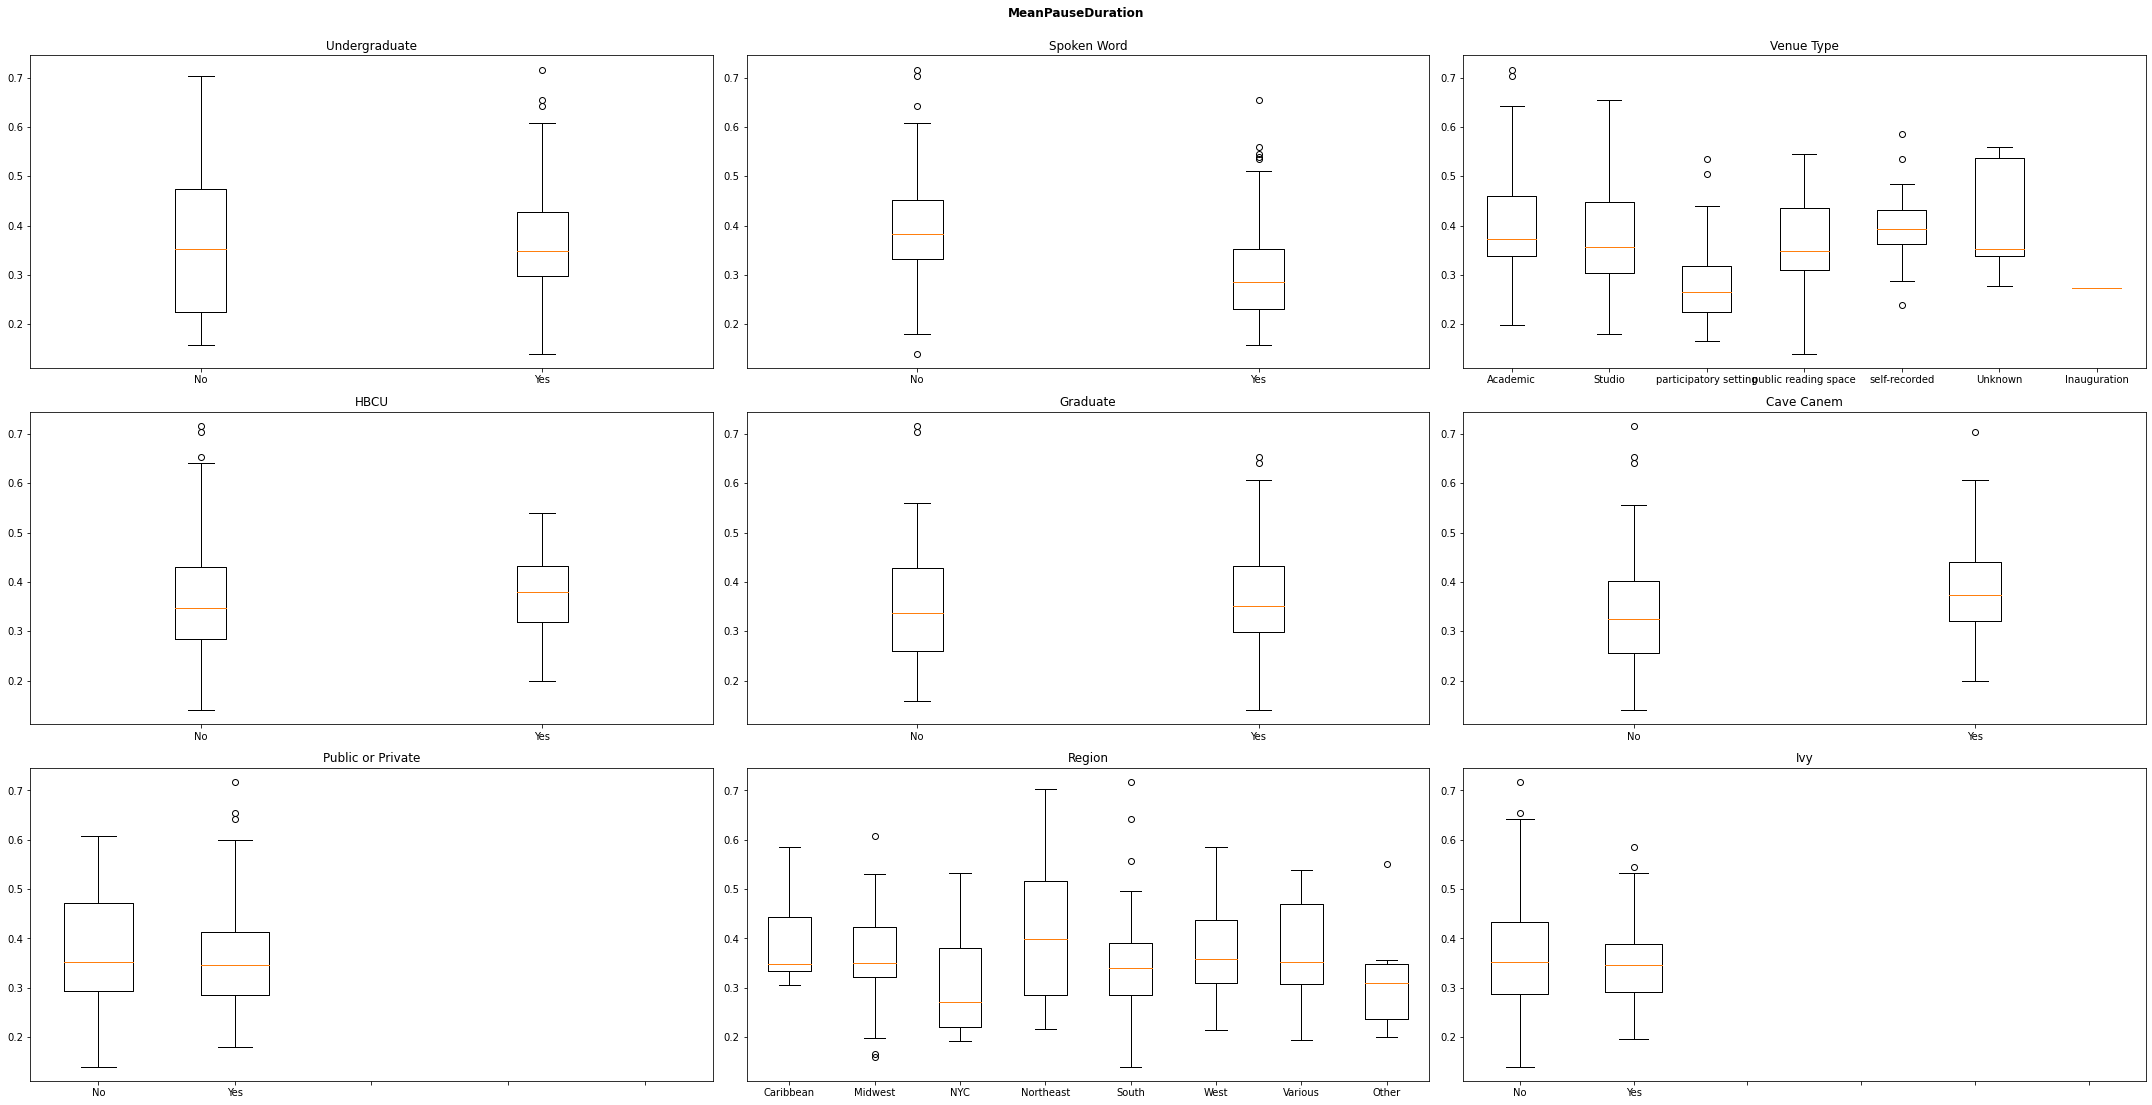

In [10]:
_ = boxplot(measure_name_vet=["MeanPauseDuration"], data_frame=data, figsize=(30,15))

## Box plots of "IntensityMeanAbsVelocity"

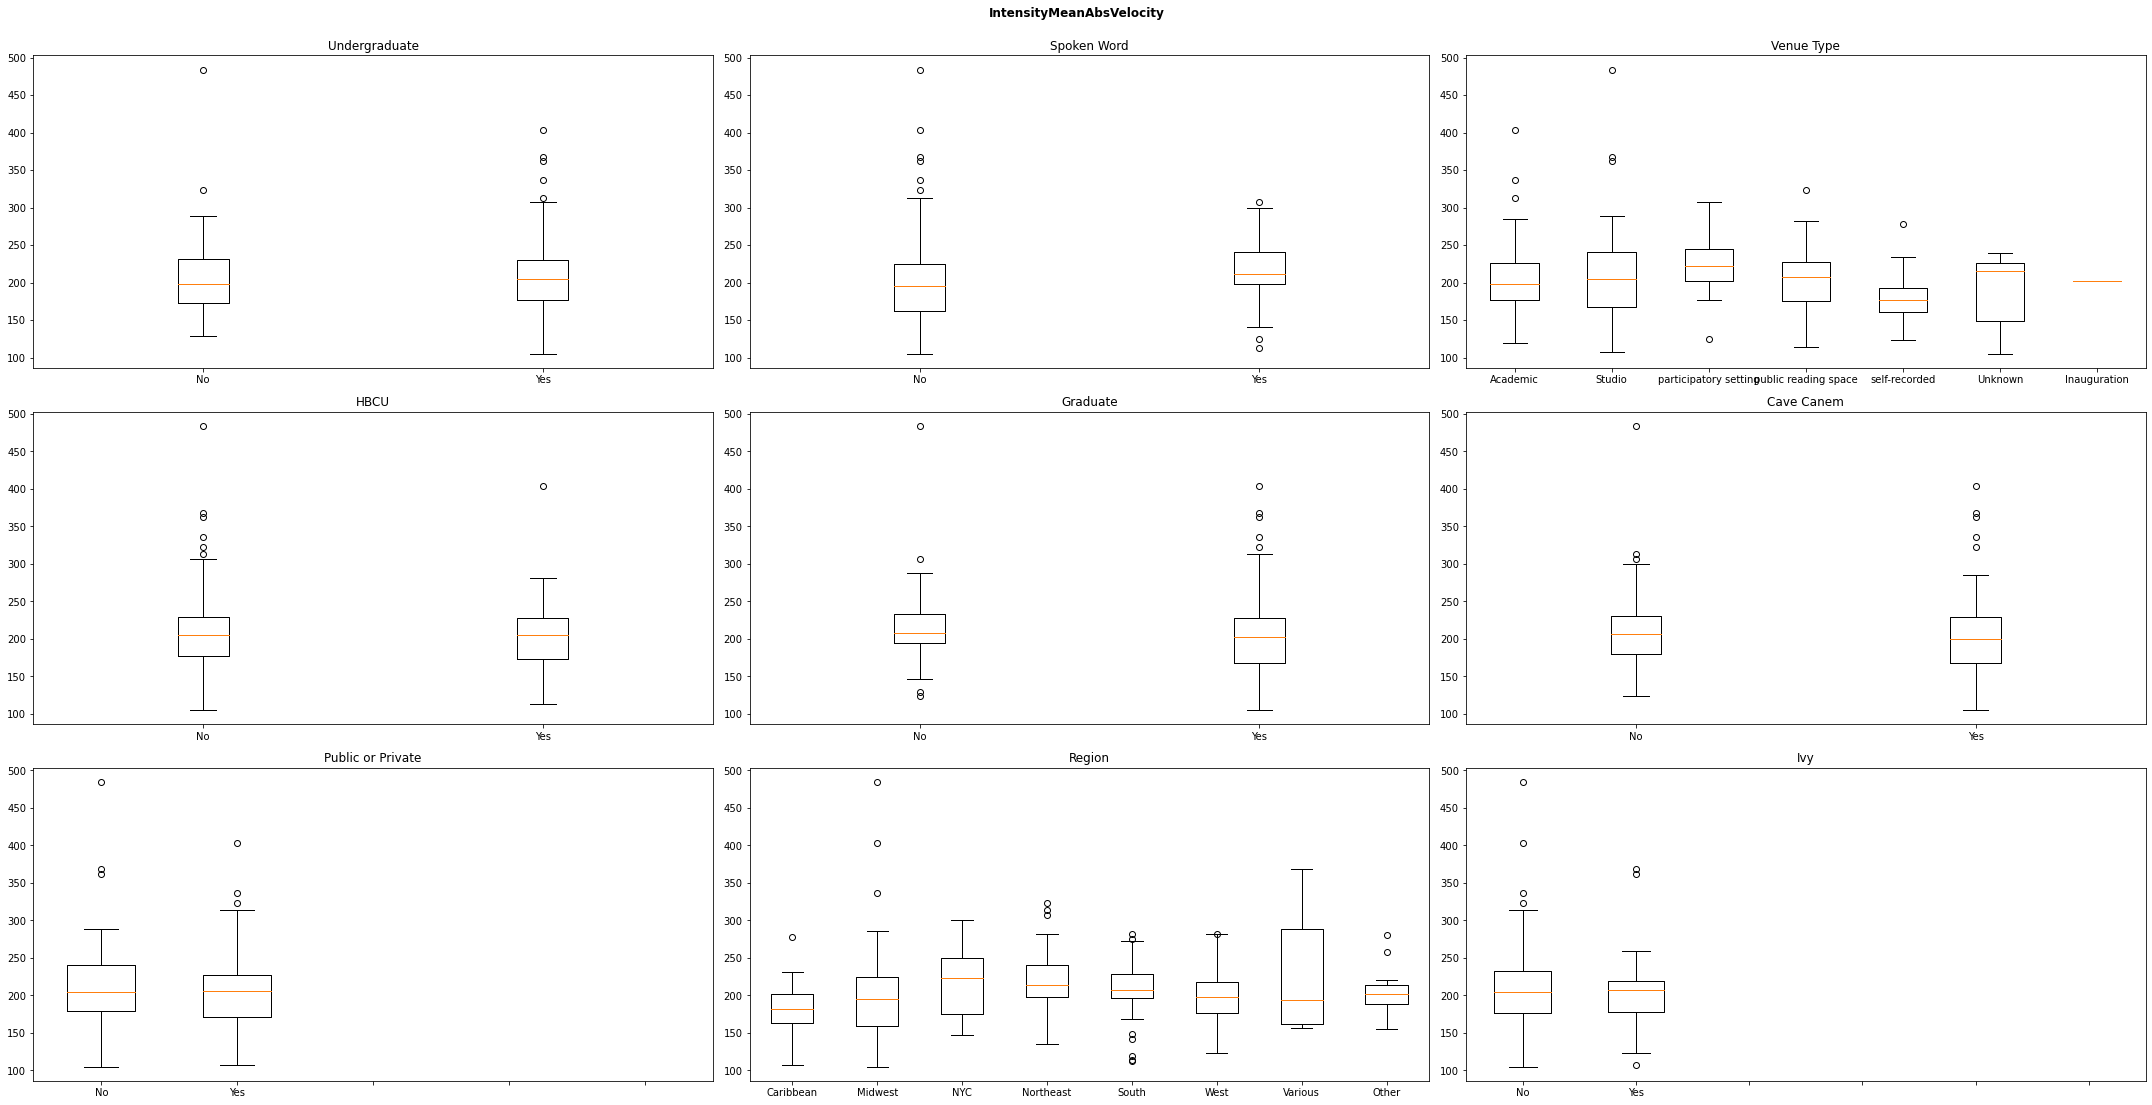

In [11]:
_ = boxplot(measure_name_vet=['IntensityMeanAbsVelocity'], data_frame=data, figsize=(30,15))

# In the following, we fit a linear fixed model to the data

## In the output, you can look at the "Coef." and "P>|z|" columns. There are several points here.
- When the coef. is neg, it means that increases the value of the variable, f0mean will decrease. 
- If coef is positive, then f0mean increases with increasing values of the variable. 
- "P>|z|" column is the p-value that shows how significant this variable is. 
- Usually, p-value has to be less than 0.05 in order to say this variable is significant, but since we have done multiple testing here, the threshold should be much less than 0.05 or 0.1. 
- For example, if we are doing $n$ tests, then the threshold for p-value should be set as $\frac{0.05}{n}$ or $\frac{0.1}{n}$. That means, only when the corresponding p-value is less than $\frac{0.05}{n}$ or $\frac{0.1}{n}$, we can say that this variable is significant to f0mean. And the same applies to the analysis for intensity, dynamism, etc.
- Taken the multiple testing issue into consideration, outputs with significant results are highlighted with blue color. I have also highlighted the result that has p-value as 0.0x (but less than 0.05) with yellow color, but rigorously, those are not signifcant results due to multiple testing.

## Linear mixed model results for "f0mean"

### Some findings for f0mean (you can also relate these results to the boxplots)
- Spoken word has positive effect on f0mean with a p-value close to 0. This means if the poet belongs to the spoken word category, the f0mean of this poet should be higher.
- If the venue type is participatory setting, f0mean should be significantly higher.

In [12]:
p_value_dict = {}

In [13]:
# f0mean
model_f0m = smf.mixedlm("f0Mean ~ birth_year + C(spoken_word) + C(hbcu) + C(venue_type) + C(cave_canem_indicator) + C(graduate_study_indicator) + C(undergrad_study_indicator) + "
                        "C(region, Treatment('Caribbean'))", data, groups=data['poet_full_name'])
f0m = model_f0m.fit()
p_value_dict["f0Mean"] = f0m.pvalues[1:-1]
print(f0m.summary())

                            Mixed Linear Model Regression Results
Model:                         MixedLM              Dependent Variable:              f0Mean   
No. Observations:              203                  Method:                          REML     
No. Groups:                    101                  Scale:                           605.4846 
Min. group size:               1                    Log-Likelihood:                  -925.0268
Max. group size:               3                    Converged:                       Yes      
Mean group size:               2.0                                                            
----------------------------------------------------------------------------------------------
                                                Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------------------------------------
Intercept                                      -288.567  339.073 -0.851 0.395 -

## Linear mixed model results for "IntensityMeanAbsVelocity"

Nothing is signficiant with here.

In [14]:
# intensity
model_intense = smf.mixedlm("IntensityMeanAbsVelocity ~ birth_year + C(spoken_word) + C(hbcu) + C(venue_type, Treatment('Academic')) + C(cave_canem_indicator) + C(graduate_study_indicator) + C(undergrad_study_indicator) + "
                        "C(region, Treatment('Caribbean'))", data, groups=data['poet_full_name'])
intense = model_intense.fit()
p_value_dict["imav"] = intense.pvalues[1:-1]
print(intense.summary())

                                   Mixed Linear Model Regression Results
Model:                          MixedLM             Dependent Variable:             IntensityMeanAbsVelocity
No. Observations:               203                 Method:                         REML                    
No. Groups:                     101                 Scale:                          2233.0030               
Min. group size:                1                   Log-Likelihood:                 -1014.9100              
Max. group size:                3                   Converged:                      Yes                     
Mean group size:                2.0                                                                         
------------------------------------------------------------------------------------------------------------
                                                               Coef.  Std.Err.   z    P>|z|  [0.025   0.975]
-------------------------------------------------------

## Linear mixed model results for "f0MeanAbsVelocity"

### Some findings for f0MeanAbsVelocity (you can also relate these results to the boxplots)

In [15]:
# f0mean abs velocity: cave, graduate, carribean
model_f0mv = smf.mixedlm("f0MeanAbsVelocity ~ birth_year + C(cave_canem_indicator) + C(spoken_word) + C(hbcu) + C(venue_type) + C(graduate_study_indicator) + C(undergrad_study_indicator) + "
                        "C(region, Treatment('Caribbean'))", data, groups=data['poet_full_name'])
f0mv = model_f0mv.fit()
p_value_dict["f0mv"] = f0mv.pvalues[1:-1]
print(f0mv.summary())

                          Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         f0MeanAbsVelocity
No. Observations:           203             Method:                     REML             
No. Groups:                 101             Scale:                      0.0847           
Min. group size:            1               Log-Likelihood:             -95.6378         
Max. group size:            3               Converged:                  Yes              
Mean group size:            2.0                                                          
-----------------------------------------------------------------------------------------
                                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                      12.177    3.339  3.647 0.000  5.633 18.722
C(cave_canem_indicator)[T.True]     

## Linear mixed model results for "Dynamism"

### Some findings for dynamism (you can also relate these results to the boxplots)
- Birth year has negative impact on dynamism. The younger the poet, the lower the dynamism.

In [16]:
# dynamism
# dyn: cave, graduate
model_dyn = smf.mixedlm("Dynamism ~ birth_year + C(cave_canem_indicator) + C(spoken_word) + C(hbcu) + C(venue_type) + C(graduate_study_indicator) + C(undergrad_study_indicator) + "
                        "C(region, Treatment('Caribbean'))", data, groups=data['poet_full_name'])
dyn = model_dyn.fit()
p_value_dict["dyn"] = dyn.pvalues[1:-1]
print(dyn.summary())

                          Mixed Linear Model Regression Results
Model:                         MixedLM            Dependent Variable:            Dynamism 
No. Observations:              203                Method:                        REML     
No. Groups:                    101                Scale:                         3.8984   
Min. group size:               1                  Log-Likelihood:                -436.9985
Max. group size:               3                  Converged:                     Yes      
Mean group size:               2.0                                                        
------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.   z    P>|z| [0.025  0.975]
------------------------------------------------------------------------------------------
Intercept                                      83.378   20.502  4.067 0.000 43.195 123.561
C(cave_canem_indicator)[T.

## Linear mixed model results for "MeanPauseDuration"

### Some findings for MeanPauseDuration (you can also relate these results to the boxplots)

In [17]:
# mean pause duration
# mpr: cave, nyc & northeast
model_pause_duration = smf.mixedlm("MeanPauseDuration ~ birth_year + C(spoken_word) + C(hbcu) + C(venue_type) + C(cave_canem_indicator) + C(graduate_study_indicator) + C(undergrad_study_indicator) + "
                              "C(region, Treatment('NYC'))", data, groups=data['poet_full_name'])
pause_duration = model_pause_duration.fit()
p_value_dict["pause_duration"] = pause_duration.pvalues[1:-1]
print(pause_duration.summary())

                       Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       MeanPauseDuration
No. Observations:         203           Method:                   REML             
No. Groups:               101           Scale:                    0.0069           
Min. group size:          1             Log-Likelihood:           139.6157         
Max. group size:          3             Converged:                Yes              
Mean group size:          2.0                                                      
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                 0.934    0.894  1.045 0.296 -0.818  2.685
C(spoken_word)[T.True]                   -0.073    0.022 -3.302 0.001 -0.117 -0.030
C(hbcu)[T.True]

In [18]:
# for res_name, p_value_series in p_value_dict.items():
#     p_value_series.index = res_name + "_" + p_value_series.index

In [19]:
p_value_series = pd.concat(p_value_dict)

In [20]:
# https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
reject_boolean, _, _, _ = smt.multipletests(p_value_series, method="fdr_bh", alpha=0.1)

# Benjemini-Hochberg Process

The following variabler

In [21]:
p_value_series[reject_boolean]

f0Mean          C(spoken_word)[T.True]                    0.000090
                C(venue_type)[T.participatory setting]    0.000002
f0mv            C(spoken_word)[T.True]                    0.003049
                birth_year                                0.000923
dyn             birth_year                                0.000305
pause_duration  C(spoken_word)[T.True]                    0.000961
dtype: float64

In [23]:
p_value_series.to_csv("data/p_values.csv")